In [3]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd

# Load just a subset directly (if the full file is too large)
df_iter = pd.read_csv('/content/drive/MyDrive/clean_flight_status.csv', chunksize=2_000_000)
df = next(df_iter)  # Loads first 2 million rows


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
df['Prev_Dest'] = df['Prev_Dest'].fillna('Not Applicable')

In [7]:
from sklearn.preprocessing import LabelEncoder

# Optional: Convert FlightDate
df['FlightDate'] = pd.to_datetime(df['FlightDate'])

# Encode all string columns
for col in df.select_dtypes(include=['object', 'string']).columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])


In [8]:
from sklearn.model_selection import train_test_split

X = df.drop(columns=['flight_status', 'FlightDate'])
y = LabelEncoder().fit_transform(df['flight_status'])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

In [9]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=15,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

rf_model.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=15, n_jobs=-1,
                       random_state=42)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      7338
           1       0.70      0.80      0.74     74444
           2       0.95      0.92      0.93    318218

    accuracy                           0.90    400000
   macro avg       0.88      0.91      0.89    400000
weighted avg       0.90      0.90      0.90    400000



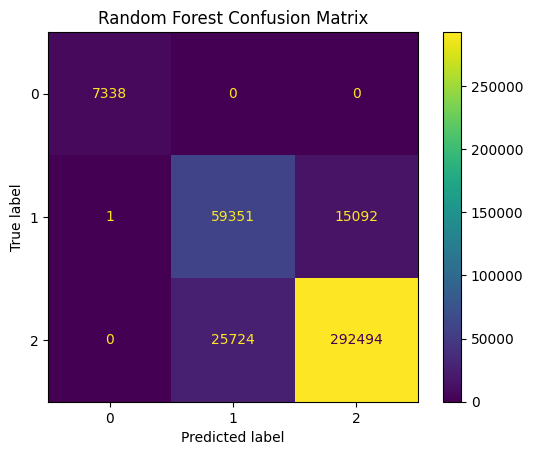

In [10]:
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

y_pred = rf_model.predict(X_test)

# Report
print(classification_report(y_test, y_pred))

# Confusion matrix
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.title("Random Forest Confusion Matrix")
plt.show()


In [12]:
from sklearn.preprocessing import label_binarize

# 3 classes: 0 = Canceled, 1 = Delayed, 2 = On Time
n_classes = 3
y_test_bin = label_binarize(y_test, classes=[0, 1, 2])

y_proba = rf_model.predict_proba(X_test)

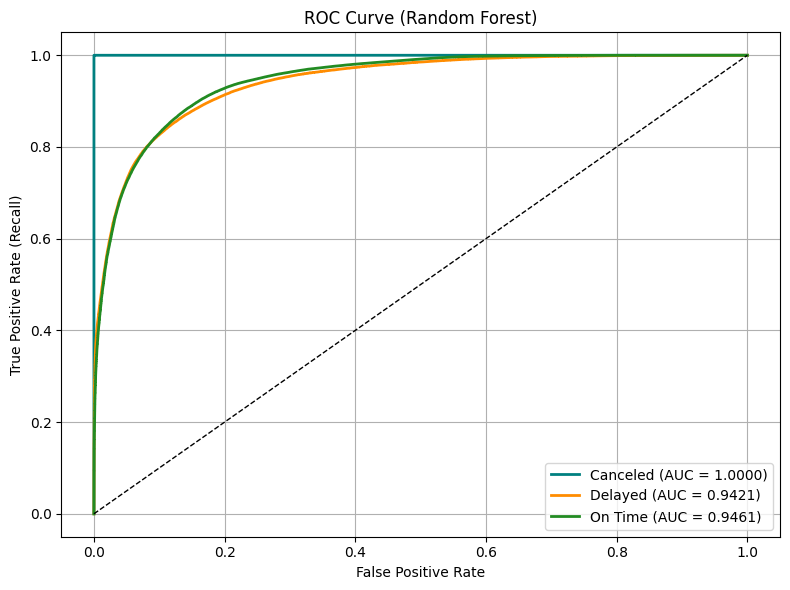

In [14]:
from sklearn.metrics import roc_curve, auc

plt.figure(figsize=(8, 6))
colors = ['teal', 'darkorange', 'forestgreen']

for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_proba[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color=colors[i], lw=2,
             label=f"{class_names[i]} (AUC = {roc_auc:.4f})")

plt.plot([0, 1], [0, 1], 'k--', lw=1)  # Random baseline
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Recall)")
plt.title("ROC Curve (Random Forest)")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

In [15]:
from sklearn.metrics import log_loss
print("Log Loss:", log_loss(y_test, y_proba))

Log Loss: 0.32557307339291597


In [16]:
import numpy as np
np.bincount(y_test)

array([  7338,  74444, 318218])

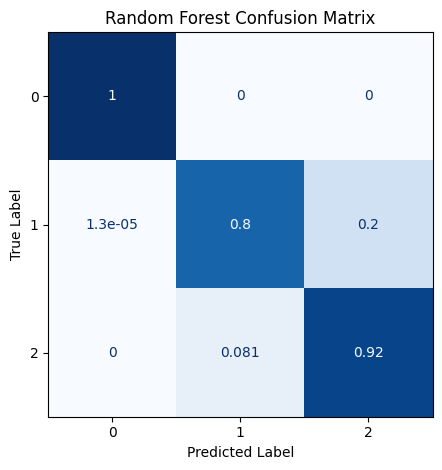

In [25]:
disp = ConfusionMatrixDisplay.from_predictions(
    y_test,
    y_pred,
    cmap='Blues',
    normalize='true'
)
disp.ax_.set_title("Random Forest Confusion Matrix")
disp.ax_.set_xlabel("Predicted Label")
disp.ax_.set_ylabel("True Label")
disp.im_.colorbar.remove()  # optional: removes colorbar
plt.tight_layout()
plt.show()


In [21]:
print(df.columns.tolist())

['FlightDate', 'Airline', 'Origin', 'Dest', 'CRSDepTime', 'ArrTime', 'CRSElapsedTime', 'Distance', 'Quarter', 'Marketing_Airline_Network', 'Year', 'Month', 'DayOfWeek', 'DOT_ID_Operating_Airline', 'Tail_Number', 'Flight_Number_Operating_Airline', 'Flight_Number_Marketing_Airline', 'OriginAirportID', 'OriginStateFips', 'DestAirportID', 'DestStateFips', 'DepTimeBlk', 'CRSArrTime', 'ArrTimeBlk', 'Operating_Airline', 'flight_status', 'Prev_Arrtime', 'Prev_Dest', 'Layover_Time', 'ShortLayover', 'Prev_ArrDelay', 'PrevFlightDelayed', 'Layover_Risk']
